# 19. Chemistry and Composition
This notebook probes the chemical and compositional characteristics of green bands using XRF data and a survey of the mineralogy of the coarse fraction of sediment. 

We show 
1. The chemical signature of the modern redox front at U1474
2. The enrichment of iron in green bands and how that relates to the green color
3. That green bands are enriched in pyrite

Code from this notebook was used to produce Figure 3

## Setup
### Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
# %matplotlib inline
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
from PIL import Image
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Patch
%matplotlib inline

### Set Paths

In [2]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
filtered_photos='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Filtered/Combined/'
raw_photos='/Volumes/SanDisk.Data/IODPU1474CorePhotos/SpliceSections/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/Supplemental/'
checkpoints_path='/Users/danielbabin/GitHub/Green_Bands/Data/Checkpoints/'

### Import Splice info

In [3]:
splice=pd.read_csv(data_path+'SpliceTables/spliceConstructionE361.csv').iloc[0:57]
splice['CoreLabel']=(splice['Site']+splice['Hole']+'_'+splice['Core'].map(str))

section_list=pd.read_csv(data_path+'SectionSummaries/sectionSummaryU1474.csv')
section_list['SectionLabel']=(section_list['Site']+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+section_list['Sect'].map(str))
section_list.rename(columns={'Top depth CCSF-361-U1474-ABDEF-20160220 (m)':'Top Depth CCSF (m)',
                            'Bottom depth CCSF-361-U1474-ABDEF-20160220 (m)':'Bottom Depth CCSF (m)'},inplace=True)
section_list['Length (m)']=section_list['Bottom Depth CCSF (m)']-section_list['Top Depth CCSF (m)']
section_list=section_list.set_index('SectionLabel')

sections=pd.read_csv(data_path+'SectionSummaries/spliceSectionsU1474.csv')['sectionLabel'].tolist()

### Import Results

In [4]:
green=pd.read_csv(table_path+'Supplementary Table 5A - U1474 green intensity splice.csv')
green=green[green['CCSF Depth (m)'].isnull()==False].copy()
green=green.set_index('CCSF Depth (m)')
green['SectionLabel']=green['Site']+green['Hole']+'_'+green['Core'].map(str)+green['Type']+green['Section'].map(str)

In [5]:
green_layers=pd.read_csv(table_path+'Supplementary Table 6A - U1474 green bands.csv')
sand_layers=pd.read_csv(table_path+'Supplementary Table X Site U1474 Sand Layers.csv')

In [6]:
ulxrf=pd.read_csv(table_path+'Supplementary Table X Site U1474 2mm-2s xrf data.csv',low_memory=False,index_col='Depth CCSF (m)')
ulxrf['SectionLabel']=(ulxrf['Site']+ulxrf['Hole']+'_'+
                              ulxrf['Core'].map(str)+ulxrf['Type']+ulxrf['Section'].map(str))
ulxrf=ulxrf[ulxrf.index.duplicated()==False]
ulxrf=ulxrf.sort_index()
ulxrf['Sr/Ca']=ulxrf['Sr']/ulxrf['Ca']
ulxrf['Ti/Ca']=ulxrf['Ti']/ulxrf['Ca']
ulxrf['Fe/Ca']=ulxrf['Fe']/ulxrf['Ca']
ulxrf['Fe/Ti']=ulxrf['Fe']/ulxrf['Ti']
ulxrf['K/Ti']=ulxrf['K']/ulxrf['Ti']
ulxrf['S/Ti']=ulxrf['S']/ulxrf['Ti']
ulxrf['S/Ca']=ulxrf['S']/ulxrf['Ca']
ulxrf['S/Fe']=ulxrf['S']/ulxrf['Fe']
ulxrf['Mn/Ti']=ulxrf['Mn']/ulxrf['Ti']

## Mask

In [7]:
ulxrf['Masked']=False


### Mask section ends

In [8]:
for i,sect in enumerate(ulxrf['SectionLabel'].unique()):
    clear_output(wait=True)
    t_ids=ulxrf[ulxrf['SectionLabel']==sect].index[:5].tolist()
    b_ids=ulxrf[ulxrf['SectionLabel']==sect].index[-5:].tolist()
    ids=t_ids+b_ids
    ends=ulxrf.loc[ids]
    final_ids=ends[ends['Fe/Ti']>=5].index.tolist()
    ulxrf.loc[final_ids,['Masked']]='Section End'

### Mask Sand

In [9]:
for i,l in enumerate(sand_layers.index):
    clear_output(wait=True)
    base=sand_layers.loc[l,'Bottom depth CCSF (m)']
    top=sand_layers.loc[l,'Top depth CCSF (m)']
    ulxrf.loc[top:base,'Masked']='Sand'
    print(i,'/',len(sand_layers))  

42 / 43


### Mask Pyrite

In [10]:
pyrite=pd.read_csv(data_path+'U1474/pyrite.in.xrf.scans.csv')

In [11]:
for i,l in enumerate(pyrite.index):
    clear_output(wait=True)
    base=pyrite.loc[l,'Bottom Depth CCSF (m)']
    top=pyrite.loc[l,'Top Depth CCSF (m)']
    ulxrf.loc[top-.0001:base+.0001,'Masked']='Pyrite'
    print(i,'/',len(pyrite))   

54 / 55


## Import Core Photos

In [18]:
cpmd=pd.read_csv(data_path+'U1474/corePhotosMetadataU1474.csv')
cpmd['SectionLabel']=cpmd['Site']+cpmd['Hole']+'_'+cpmd['Core'].map(str)+cpmd['Type']+cpmd['Sect'].map(str)
cpmd['Cropped image filename (JPEG)']=cpmd['Cropped image filename'].str[:-4]+'.jpeg'
cpmd.set_index('SectionLabel',inplace=True)
cpmd=cpmd[cpmd['Display status (T/F)']=='T']

In [22]:
rphot={}
fphot={}
start=time.time()
for i,s in enumerate(sections):
    clear_output(wait=True)
    rphot[s] = Image.open(raw_photos+cpmd.loc[s,'Cropped image filename'])
    fphot[s] = Image.open(filtered_photos+cpmd.loc[s,'Cropped image filename'])
    
    stop=time.time()-start
    if i/len(sections)*100<2:
        expected_time='Calculating...'
    else:
        expected_time=np.round((stop-0)/(i/len(sections))/60,2)
    print('Current progress: ',np.round(i/len(sections)*100,2),'%')
    print('Current run time: ',np.round((stop-0)/60,2),' minutes')
    print('Expected run time: ',expected_time,' minutes')

Current progress:  99.54 %
Current run time:  1.57  minutes
Expected run time:  1.58  minutes


In [23]:
aspects=[]
for i,sect in enumerate(sections):
    shp=rphot[sect].size
    aspects.append(shp[0]/shp[1])
aspects=np.array(aspects)

## Colors

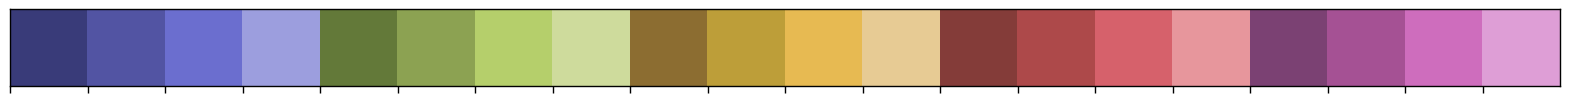

In [24]:
colors=sns.color_palette('tab20b')
sns.palplot(colors)

## Modern Redox Front

In [25]:
green_colors=sns.color_palette('viridis',50)
green_colors

[(0.273809, 0.031497, 0.358853),
 (0.278791, 0.062145, 0.386592),
 (0.281924, 0.089666, 0.412415),
 (0.283197, 0.11568, 0.436115),
 (0.282623, 0.140926, 0.457517),
 (0.280255, 0.165693, 0.476498),
 (0.276194, 0.190074, 0.493001),
 (0.270595, 0.214069, 0.507052),
 (0.263663, 0.237631, 0.518762),
 (0.255645, 0.260703, 0.528312),
 (0.246811, 0.283237, 0.535941),
 (0.237441, 0.305202, 0.541921),
 (0.227802, 0.326594, 0.546532),
 (0.21813, 0.347432, 0.550038),
 (0.208623, 0.367752, 0.552675),
 (0.19943, 0.387607, 0.554642),
 (0.190631, 0.407061, 0.556089),
 (0.182256, 0.426184, 0.55712),
 (0.174274, 0.445044, 0.557792),
 (0.166617, 0.463708, 0.558119),
 (0.159194, 0.482237, 0.558073),
 (0.151918, 0.500685, 0.557587),
 (0.144759, 0.519093, 0.556572),
 (0.13777, 0.537492, 0.554906),
 (0.131172, 0.555899, 0.552459),
 (0.125394, 0.574318, 0.549086),
 (0.121148, 0.592739, 0.544641),
 (0.119423, 0.611141, 0.538982),
 (0.12138, 0.629492, 0.531973),
 (0.128087, 0.647749, 0.523491),
 (0.14021, 0.665859, 0.513427),
 (0.157851, 0.683765, 0.501686),
 (0.180653, 0.701402, 0.488189),
 (0.20803, 0.718701, 0.472873),
 (0.239374, 0.735588, 0.455688),
 (0.274149, 0.751988, 0.436601),
 (0.311925, 0.767822, 0.415586),
 (0.35236, 0.783011, 0.392636),
 (0.395174, 0.797475, 0.367757),
 (0.440137, 0.811138, 0.340967),
 (0.487026, 0.823929, 0.312321),
 (0.535621, 0.835785, 0.281908),
 (0.585678, 0.846661, 0.249897),
 (0.636902, 0.856542, 0.21662),
 (0.688944, 0.865448, 0.182725),
 (0.741388, 0.873449, 0.149561),
 (0.79376, 0.880678, 0.120005),
 (0.845561, 0.887322, 0.099702),
 (0.89632, 0.893616, 0.096335),
 (0.945636, 0.899815, 0.112838)]

In [26]:
## I set the alpha to .2 and then went to an image color picker. 
#The bars blend together and it looks bad if i don't do this 
green_colors_no_alpha=['#f0ebf2','#edf6f5','#fdfced']

In [27]:
from matplotlib.patches import Patch

Text(-0.04, 1.1, 'C')

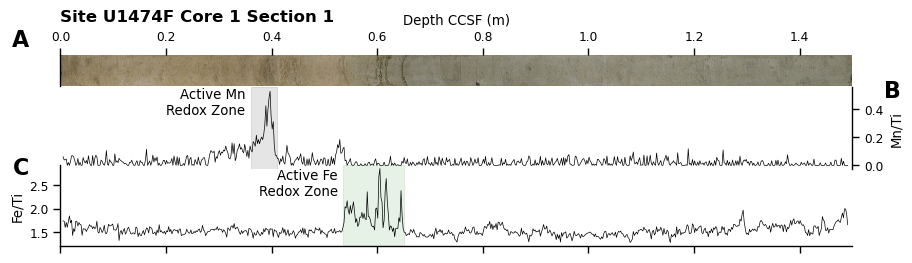

In [28]:
n=0
numbers=[n]
sns.set_context('paper')
################################ Set up
fig=plt.figure(figsize=(9,2.5),facecolor='white')
gs = gridspec.GridSpec(5, 1, figure=fig,hspace=-.1,left=.06,right=.94,top=.83,bottom=.04)

ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1:3,:])
ax3=fig.add_subplot(gs[3:,:])

### despine
for ax in [ax2,ax3]:
    ax.patch.set_alpha(0)
ax2.xaxis.set_visible(False)
for ax in [ax1]:
    ax.patch.set_alpha(0)
    
sns.despine(ax=ax2,top=True,bottom=True,right=False,left=True)
sns.despine(ax=ax3,top=True,bottom=False,right=True,left=False)

ax2.yaxis.set_label_position('right')

################################ Plot 

#################### Images

sect=sections[n]
sect_length=(section_list.loc[sect,'Bottom Depth CCSF (m)']-
              section_list.loc[sect,'Top Depth CCSF (m)'])
extentlist=[section_list.loc[sect,'Bottom Depth CCSF (m)'],
            section_list.loc[sect,'Top Depth CCSF (m)'],0,sect_length/aspects[n]]

ax1.imshow(rphot[sect].rotate(180, Image.NEAREST, expand = 1),extent=extentlist)

for ax in [ax1]:
    sns.despine(ax=ax,top=True,bottom=True,left=False,right=True)
    ax.yaxis.set_visible(False)
    
ax1.set_xlabel('Depth CCSF (m)')
ax3.set_xticklabels([])
ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()

### setup columns
feti=ulxrf.loc[ulxrf['SectionLabel']==sect,'Fe/Ti']
mnti=ulxrf.loc[ulxrf['SectionLabel']==sect,'Mn/Ti']

ax2.plot(mnti.dropna().index,mnti.dropna(),color='k',lw=.5)
ax3.plot(feti.dropna().index,feti.dropna(),color='k',lw=.5)

###### Title
ax1.annotate('Site '+sect[:6]+' Core '+sect[7]+' Section '+sect[9],
            xy=(0,2.2),xycoords='axes fraction',
            verticalalignment='center',horizontalalignment='left',fontweight='bold',
            size=12)

################################### coloring
sect_top=section_list.loc[sect,'Top Depth CCSF (m)']
sect_bottom=section_list.loc[sect,'Bottom Depth CCSF (m)']

ax2.axvspan(xmin=.36,xmax=.41,color='k',alpha=.1)
ax2.annotate('Active Mn\nRedox Zone',xy=(.35,.555),xycoords='data',ha='right',va='top')
ax3.axvspan(xmin=.535,xmax=.65,color='g',alpha=.1)
ax3.annotate('Active Fe\nRedox Zone',xy=(.525,2.85),xycoords='data',ha='right',va='top')


### Labels
ax2.set_ylabel('Mn/Ti')
ax3.set_ylabel('Fe/Ti')

### ylims
for i,a in enumerate([ax1,ax2,ax3]):
    a.set_xlim(section_list.loc[sect,'Top Depth CCSF (m)'],
               section_list.loc[sect,'Bottom Depth CCSF (m)'])
    
ax1.annotate('A',xy=(-.04,1.1),ha='right',va='bottom',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)
ax2.annotate('B',xy=(1.04,1.1),ha='left',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)
ax3.annotate('C',xy=(-.04,1.1),ha='right',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)

# fig.savefig(figure_path+'modernFronts.png',dpi=300)

## Iron Enrichment
### Core Exhibit Vertical

In [29]:
# n=32
# numbers=[n]
# sns.set_context('paper')
# ################################ Set up
# fig=plt.figure(figsize=(3,9),facecolor='white')
# gs = gridspec.GridSpec(1, 6, figure=fig,wspace=-.1,left=.2,right=.95,top=.92,bottom=.05)

# ax1=fig.add_subplot(gs[:,0])
# ax2=fig.add_subplot(gs[:,1])
# ax3=fig.add_subplot(gs[:,2:4])
# ax4=fig.add_subplot(gs[:,4:])
# sec=ax3.twiny()

# ### despine
# for ax in [ax3,ax4,sec]:
#     ax.patch.set_alpha(0)
#     ax.yaxis.set_visible(False)
# for ax in [ax1,ax2]:
#     ax.patch.set_alpha(0)
    
# sns.despine(ax=ax3,top=False,bottom=True,right=True,left=True)
# sns.despine(ax=sec,top=True,bottom=False,right=True,left=True)
# sns.despine(ax=ax4,top=True,bottom=False,right=True,left=True)

# sec.xaxis.set_label_position('bottom')
# sec.xaxis.tick_bottom()
# ax3.xaxis.set_label_position('top')

# ################################ Plot 

# #################### Images

# sect=sections[n]
# sect_length=(section_list.loc[sect,'Bottom Depth CCSF (m)']-
#               section_list.loc[sect,'Top Depth CCSF (m)'])
# extentlist=[0,sect_length/aspects[n],
#             section_list.loc[sect,'Bottom Depth CCSF (m)'],
#             section_list.loc[sect,'Top Depth CCSF (m)']]

# ax1.imshow(rphot[sect].rotate(270, Image.NEAREST, expand = 1),extent=extentlist)
# ax2.imshow(fphot[sect].rotate(270, Image.NEAREST, expand = 1),extent=extentlist)

# for ax in [ax1,ax2]:
#     sns.despine(ax=ax,top=True,bottom=True,left=False,right=True)
#     ax.xaxis.set_visible(False)
    
# ax1.set_ylabel('Depth CCSF (m)')
# ax2.yaxis.set_visible(False)

# ### setup columns
# feti=ulxrf.loc[(feti_masked['SectionLabel']==sect)&(ulxrf['Masked']==False),'Fe/Ti']
# green_data=green.loc[green['SectionLabel']==sect,'Green%']

# ax3.plot(green_data.values,green_data.index,color='k',lw=.5)
# ax4.plot(feti.dropna(),feti.dropna().index,color='k',lw=.5)

# ###### Title
# ax1.annotate(sect[:6]+'-'+sect[7:],
#             xy=(.17,.98),xycoords='figure fraction',
#             verticalalignment='center',horizontalalignment='left',fontweight='bold',
#             size=10)

# ################################### coloring
# sect_top=section_list.loc[sect,'Top Depth CCSF (m)']
# sect_bottom=section_list.loc[sect,'Bottom Depth CCSF (m)']
# #### green
# sect_green=green_layers.loc[(green_layers['Top Depth CCSF (m)']>=sect_top-.1)&
#                             (green_layers['Bottom Depth CCSF (m)']<=sect_bottom+.1)&
#                             (green_layers['Top Depth CCSF (m)']>=green_data.index.min()-.1)&
#                             (green_layers['Bottom Depth CCSF (m)']<=green_data.index.max()+.1)]
# sect_green=sect_green.loc[sect_green['Splice']=='A']

# for gl in sect_green.index:
#     if sect_green.loc[gl,'Class']==1:
#         c=green_colors_no_alpha[0]
#         for ax in [ax3,ax4]:
#             ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
#                        ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
#                        color=c,zorder=-1)
#     elif sect_green.loc[gl,'Class']==2:
#         c=green_colors_no_alpha[1]
#         for ax in [ax3,ax4]:
#             ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
#                        ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
#                        color=c,zorder=-1)
#     elif sect_green.loc[gl,'Class']==3:
#         c=green_colors_no_alpha[2]
#         for ax in [ax3,ax4]:
#             ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
#                        ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
#                        color=c,zorder=-1)
            
# legend_elements = [Patch(facecolor=green_colors_no_alpha[2], edgecolor='k', label='Class 3'),
#                    Patch(facecolor=green_colors_no_alpha[1], edgecolor='k', label='Class 2'),
#                    Patch(facecolor=green_colors_no_alpha[0], edgecolor='k', label='Class 1')]
# ax4.legend(handles=legend_elements, loc=(0,1.01))

# #### black
# # sect_black=black_dots.loc[(black_dots['Top Depth CCSF (m)']>=sect_top-.1)&
# #                           (black_dots['Bottom Depth CCSF (m)']<=sect_bottom+.1)&
# #                           (black_dots['Top Depth CCSF (m)']>=black_data.index.min()-.1)&
# #                           (black_dots['Bottom Depth CCSF (m)']<=black_data.index.max()+.1)]
# # for bd in sect_black.index:
# #     for ax in [ax3]:
# #         ax.axhspan(ymin=sect_black.loc[bd,'Top Depth CCSF (m)'],
# #                    ymax=sect_black.loc[bd,'Bottom Depth CCSF (m)'],
# #                    color='#fff9eb')
        
# #### sand       
# sect_sand=sand_layers.loc[(sand_layers['Top Depth CCSF (m)']>=sect_top-.1)&
#                           (sand_layers['Bottom Depth CCSF (m)']<=sect_bottom+.1)&
#                           (sand_layers['Top Depth CCSF (m)']>=green_data.index.min()-.1)&
#                           (sand_layers['Bottom Depth CCSF (m)']<=green_data.index.max()+.1)]
# for sl in sect_sand.index:
#     for ax in [ax3]:
#         if sect_sand.loc[sl,'Classification']=='Turbidite':
#             sc='#ffebec'
#         else:
#             sc='#e0e1ff'
#         ax.axhspan(ymin=sect_sand.loc[sl,'Bottom Depth CCSF (m)']-.02,
#                    ymax=sect_sand.loc[sl,'Top Depth CCSF (m)'],
#                    color=sc)

# ### Labels
# ax3.set_xlabel('Green Pixels [%]')
# # sec.set_xlabel('Black %')
# ax4.set_xlabel('Fe/Ti')

# ### ylims
# for i,a in enumerate([ax1,ax2,ax3,ax4]):
#     a.set_ylim(section_list.loc[sect,'Bottom Depth CCSF (m)'],
#                section_list.loc[sect,'Top Depth CCSF (m)'])

# fig.savefig(figure_path+'coreExhibitVertical.png',dpi=300)

### Core Exhibit Horizontal

In [30]:
colors

[(0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
 (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
 (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
 (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
 (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
 (0.5490196078431373, 0.6352941176470588, 0.3215686274509804),
 (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
 (0.807843137254902, 0.8588235294117647, 0.611764705882353),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
 (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
 (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
 (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
 (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
 (0.4823529411764706, 0.2549019607843137, 0.45098039215686275),
 (0.6470588235294118, 0.3176470588235294, 0.5803921568627451),
 (0.807843137254902, 0.42745098039215684, 0.7411764705882353),
 (0.8705882352941177, 0.6196078431372549, 0.8392156862745098)]

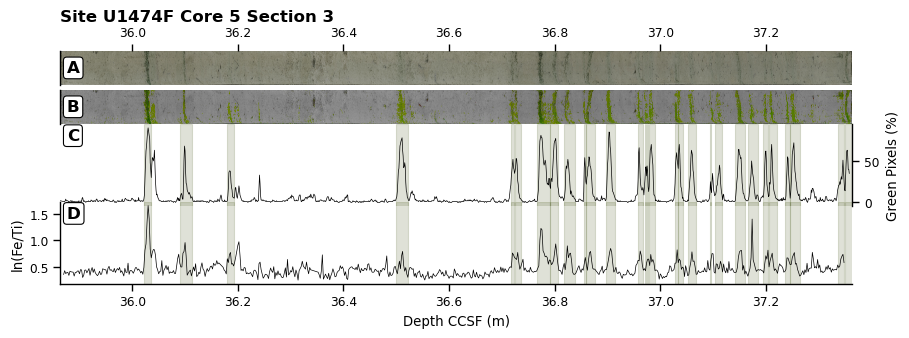

In [31]:
n=32
numbers=[n]
sns.set_context('paper')
################################ Set up
fig=plt.figure(figsize=(9,3.3),facecolor='white')
gs = gridspec.GridSpec(6, 1, figure=fig,hspace=-.1,left=.06,right=.94,top=.86,bottom=.14)

ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1,:])
ax3=fig.add_subplot(gs[2:4,:])
ax4=fig.add_subplot(gs[4:,:])

### despine
for ax in [ax3,ax4]:
    ax.patch.set_alpha(0)
ax3.xaxis.set_visible(False)
for ax in [ax1,ax2]:
    ax.patch.set_alpha(0)
    
sns.despine(ax=ax3,top=True,bottom=True,right=False,left=True)
sns.despine(ax=ax4,top=True,bottom=False,right=True,left=False)

ax3.yaxis.set_label_position('right')

################################ Plot 

#################### Images

sect=sections[n]
sect_length=(section_list.loc[sect,'Bottom Depth CCSF (m)']-
              section_list.loc[sect,'Top Depth CCSF (m)'])
extentlist=[section_list.loc[sect,'Bottom Depth CCSF (m)'],
            section_list.loc[sect,'Top Depth CCSF (m)'],0,sect_length/aspects[n]]

ax1.imshow(rphot[sect].rotate(180, Image.NEAREST, expand = 1),extent=extentlist)
ax2.imshow(fphot[sect].rotate(180, Image.NEAREST, expand = 1),extent=extentlist)

for ax in [ax1,ax2]:
    sns.despine(ax=ax,top=True,bottom=True,left=False,right=True)
    ax.yaxis.set_visible(False)
    
ax4.set_xlabel('Depth CCSF (m)')
# ax4.set_xticklabels([])
ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)

### setup columns
feti=ulxrf.loc[(ulxrf['SectionLabel']==sect)&(ulxrf['Masked']==False),'Fe/Ti'].apply(np.log)
green_data=green.loc[green['SectionLabel']==sect,'Green%']

ax3.plot(green_data.index,green_data.values,color='k',lw=.5)
ax4.plot(feti.dropna().index,feti.dropna(),color='k',lw=.5)

###### Title
ax1.annotate('Site '+sect[:6]+' Core '+sect[7]+' Section '+sect[9],
            xy=(0,2),xycoords='axes fraction',
            verticalalignment='center',horizontalalignment='left',fontweight='bold',
            size=12)

################################### coloring
sect_top=section_list.loc[sect,'Top Depth CCSF (m)']
sect_bottom=section_list.loc[sect,'Bottom Depth CCSF (m)']
#### green
sect_green=green_layers.loc[(green_layers['Top Depth CCSF (m)']>=sect_top-.1)&
                            (green_layers['Bottom Depth CCSF (m)']<=sect_bottom+.1)&
                            (green_layers['Top Depth CCSF (m)']>=green_data.index.min()-.1)&
                            (green_layers['Bottom Depth CCSF (m)']<=green_data.index.max()+.1)]

for gl in sect_green.index:
    if sect_green.loc[gl,'Class']==1:
        c='#606C38'
        for ax in [ax3,ax4]:
            ax.axvspan(xmin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                       xmax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                       color=c,zorder=-1,alpha=.2)
    elif sect_green.loc[gl,'Class']==2:
        c='#606C38'
        for ax in [ax3,ax4]:
            ax.axvspan(xmin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                       xmax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                       color=c,zorder=-1,alpha=.2)
    elif sect_green.loc[gl,'Class']==3:
        c='#606C38'
        for ax in [ax3,ax4]:
            ax.axvspan(xmin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                       xmax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                       color=c,zorder=-1,alpha=.2)
            

#### black
# sect_black=black_dots.loc[(black_dots['Top Depth CCSF (m)']>=sect_top-.1)&
#                           (black_dots['Bottom Depth CCSF (m)']<=sect_bottom+.1)&
#                           (black_dots['Top Depth CCSF (m)']>=black_data.index.min()-.1)&
#                           (black_dots['Bottom Depth CCSF (m)']<=black_data.index.max()+.1)]
# for bd in sect_black.index:
#     for ax in [ax3]:
#         ax.axhspan(ymin=sect_black.loc[bd,'Top Depth CCSF (m)'],
#                    ymax=sect_black.loc[bd,'Bottom Depth CCSF (m)'],
#                    color='#fff9eb')
        
#### sand       
sect_sand=sand_layers.loc[(sand_layers['Top depth CCSF (m)']>=sect_top-.1)&
                          (sand_layers['Bottom depth CCSF (m)']<=sect_bottom+.1)&
                          (sand_layers['Top depth CCSF (m)']>=green_data.index.min()-.1)&
                          (sand_layers['Bottom depth CCSF (m)']<=green_data.index.max()+.1)]
for sl in sect_sand.index:
    for ax in [ax3]:
        if sect_sand.loc[sl,'Classification']=='Turbidite':
            sc='#ffebec'
        else:
            sc='#e0e1ff'
        ax.axhspan(ymin=sect_sand.loc[sl,'Bottom depth CCSF (m)']-.02,
                   ymax=sect_sand.loc[sl,'Top depth CCSF (m)'],
                   color=sc)

### Labels
ax3.set_ylabel('Green Pixels (%)')
ax4.set_ylabel('ln(Fe/Ti)')

### ylims
for i,a in enumerate([ax1,ax2,ax3,ax4]):
    a.set_xlim(section_list.loc[sect,'Top Depth CCSF (m)'],
               section_list.loc[sect,'Bottom Depth CCSF (m)'])
    
ax1.annotate('A',xy=(0.008,.5),ha='left',va='center',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
ax2.annotate('B',xy=(0.008,.5),ha='left',va='center',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
ax3.annotate('C',xy=(0.008,.95),ha='left',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
ax4.annotate('D',xy=(0.008,.95),ha='left',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))

fig.savefig(figure_path+'Figure 3 - Green banding at U1474.png',dpi=300)

### Cross Plot

In [32]:
fgreen=interpolate.interp1d(green.loc[0:50].index,green['Green%'].loc[0:50],bounds_error=False)
ulxrf['Green%']=fgreen(ulxrf.index)

Text(1.27, 1, 'B')

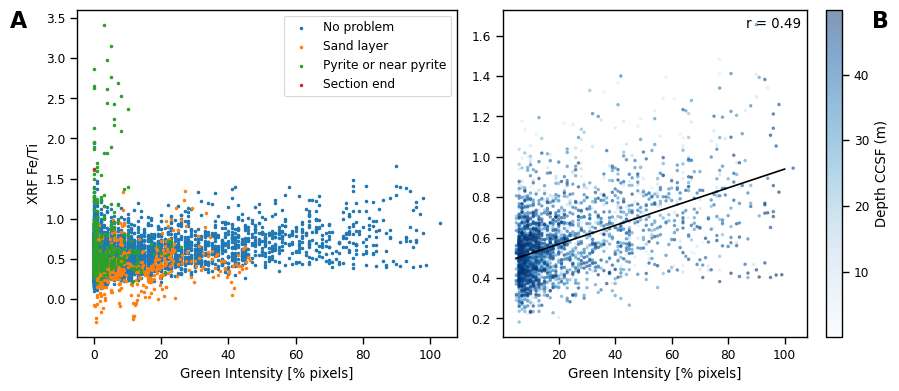

In [33]:
fig,axes=plt.subplots(ncols=2,figsize=(9,4))
ax=axes[0]
good=ulxrf.loc[ulxrf['Masked']==False].copy()
sand=ulxrf.loc[ulxrf['Masked']=='Sand'].copy()
ends=ulxrf.loc[ulxrf['Masked']=='Section End'].copy()
pys=ulxrf.loc[ulxrf['Masked']=='Pyrite'].copy()

ax.scatter(good['Green%'],np.log(good['Fe/Ti']),label='No problem',marker='o',s=3)
ax.scatter(sand['Green%'],np.log(sand['Fe/Ti']),label='Sand layer',marker='o',s=3)
ax.scatter(pys['Green%'],np.log(pys['Fe/Ti']),label='Pyrite or near pyrite',marker='o',s=3)
ax.scatter(ends['Green%'],np.log(ends['Fe/Ti']),label='Section end',marker='o',s=3)
ax.legend()
ax.set_ylabel('XRF Fe/Ti')
ax.set_xlabel('Green Intensity [% pixels]')

ax=axes[1]
regress_group=good.loc[good['Green%']>5,['Green%','Fe/Ti']]
regstats=stats.linregress(regress_group.dropna()['Green%'],np.log(regress_group.dropna()['Fe/Ti']))
cax=ax.scatter(regress_group['Green%'],np.log(regress_group['Fe/Ti']),
               c=regress_group.index,marker='o',s=3,alpha=.5,cmap='Blues')

xs=np.linspace(5,100,11)
ax.plot(xs,regstats.slope*xs+regstats.intercept,color='k')
ax.annotate('r = '+str(round(regstats.rvalue,2)),xy=(.98,.98),xycoords='axes fraction',ha='right',va='top')


ax.set_xlabel('Green Intensity [% pixels]')
plt.colorbar(cax,ax=ax,label='Depth CCSF (m)')

plt.tight_layout()

axes[0].annotate('A',xy=(-.13,1),ha='right',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)
axes[1].annotate('B',xy=(1.27,1),ha='right',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)

# fig.savefig(figure_path+'crossplot.png',dpi=300)

## Coarse Fraction Study

In [34]:
cf=pd.read_csv(data_path+'U1474/glauconite_search_U1474F_5H3.csv')
cf['Middle Depth CCSF (m)']=(cf['Top Depth CCSF (m)']+cf['Bottom Depth CCSF (m)'])/2
cf=cf.set_index('Middle Depth CCSF (m)')

In [35]:
mis_depths=pd.read_csv(checkpoints_path+'U1474 Marine Isotope Stage Depths.csv',index_col='MIS')

In [36]:
benthic=pd.read_csv(table_path+'Supplementary Table 1 - Benthic foram chemistry.csv',index_col='Top depth CCSF (m)')

In [37]:
cbcolors=sns.color_palette('colorblind')
cbcolors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [38]:
aspect_ratio_adjust=1.1

In [39]:
n=32
numbers=[n]
sect=sections[n]
bottom=section_list.loc[sect,'Bottom Depth CCSF (m)']
top=section_list.loc[sect,'Top Depth CCSF (m)']

In [40]:
sample=benthic.loc[36.7:].index[0]

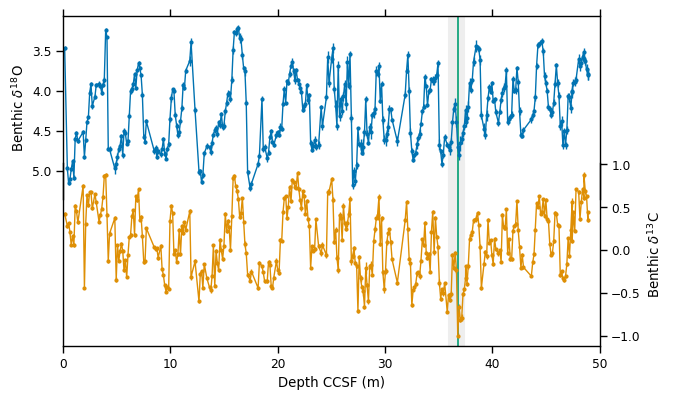

In [41]:
fig,axes=plt.subplots(nrows=2,figsize=(7.5/aspect_ratio_adjust,4.5/aspect_ratio_adjust),
                      sharex=True)

sns.despine(ax=axes[0],top=False,bottom=True,right=False)
sns.despine(ax=axes[1],top=True,bottom=False,right=False)

for ax in axes:
    ax.patch.set_visible(False)

axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position('right')

ax=axes[0]
benthic.loc[:50,'benthic d18O'].dropna().plot(yerr=benthic.loc[:50,'s d18O'],ax=ax,lw=1,marker='o',ms=2,
                                              color=cbcolors[0])
ax.set_ylabel('Benthic $\delta^{18}$O')
ax.invert_yaxis()

ax=axes[1]
benthic.loc[:50,'benthic d13C'].dropna().plot(yerr=benthic.loc[:50,'s d13C'],ax=ax,lw=1,marker='o',ms=2,
                                              color=cbcolors[1])
ax.set_ylabel('Benthic $\delta^{13}$C')

ax.set_xlim(0,50)
ax.set_xlabel('Depth CCSF (m)')

for ax in axes:
    ax.axvspan(xmin=top,xmax=bottom,color='#eeeeee')
    ax.axvline(sample,color=cbcolors[2])
    
plt.tight_layout()
plt.subplots_adjust(hspace=-.2)
fig.savefig('/Users/danielbabin/Downloads/'+'sectionTarget.png',dpi=300)

In [42]:
kind1='Pyrite > 250 (mg/g sample)'
kind2='Glauconite (grains/mg Sample)'

In [43]:
n=32

Text(0, -0.005, 'J')

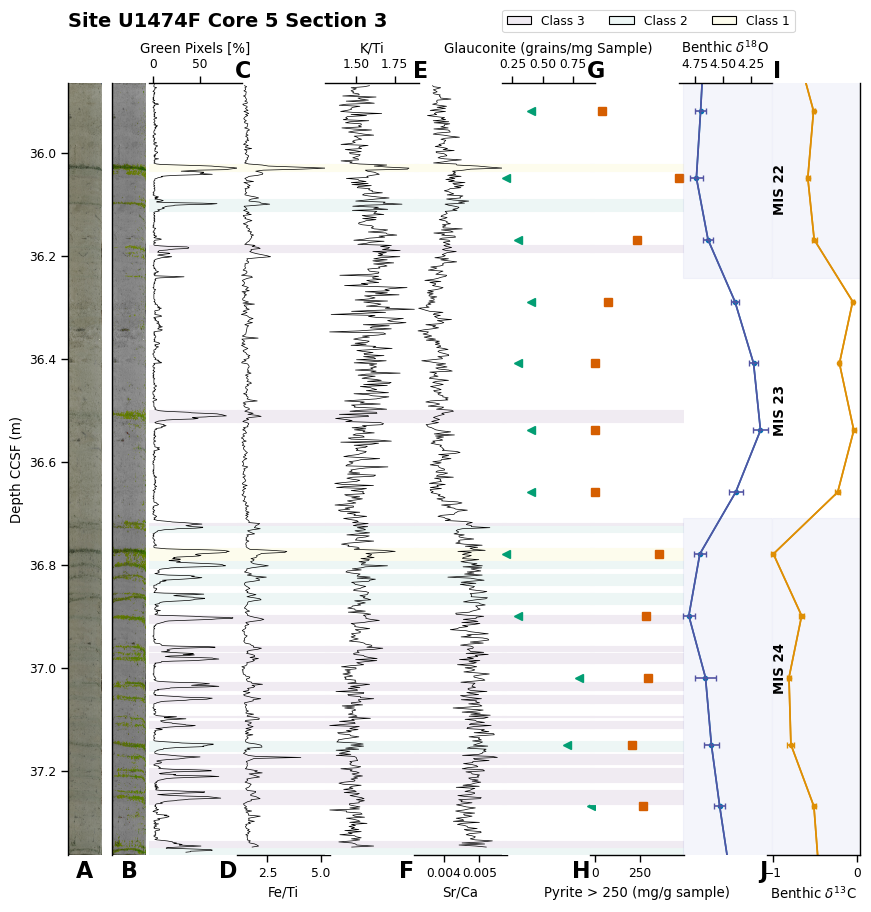

In [44]:
################################ Set up
fig=plt.figure(figsize=(10/aspect_ratio_adjust,10/aspect_ratio_adjust),facecolor='white')
gs = gridspec.GridSpec(1, 18, figure=fig,wspace=-.1,left=.07,right=.95,top=.91,bottom=.06)

ax1=fig.add_subplot(gs[:,0])
ax2=fig.add_subplot(gs[:,1])
ax3=fig.add_subplot(gs[:,2:4])
ax4=fig.add_subplot(gs[:,4:6])
ax5=fig.add_subplot(gs[:,6:8])
ax6=fig.add_subplot(gs[:,8:10])
ax7=fig.add_subplot(gs[:,10:12])
ax8=fig.add_subplot(gs[:,12:14])
ax9=fig.add_subplot(gs[:,14:16])
ax10=fig.add_subplot(gs[:,16:18])

### despine
for ax in [ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]:
    ax.patch.set_alpha(0)
    ax.yaxis.set_visible(False)
for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]:
    ax.patch.set_alpha(0)

sns.despine(ax=ax3,top=False,bottom=True,right=True,left=True)
sns.despine(ax=ax4,top=True,bottom=False,right=True,left=True)
sns.despine(ax=ax5,top=False,bottom=True,right=True,left=True)
sns.despine(ax=ax6,top=True,bottom=False,right=True,left=True)
sns.despine(ax=ax7,top=False,bottom=True,right=True,left=True)
sns.despine(ax=ax8,top=True,bottom=False,right=True,left=True)
sns.despine(ax=ax9,top=False,bottom=True,right=True,left=True)
sns.despine(ax=ax10,top=True,bottom=False,right=False,left=True)


ax3.xaxis.set_label_position('top')
ax5.xaxis.set_label_position('top')
ax7.xaxis.set_label_position('top')
ax9.xaxis.set_label_position('top')


################################ Plot 

#################### Images

sect=sections[n]
sect_length=(section_list.loc[sect,'Bottom Depth CCSF (m)']-
              section_list.loc[sect,'Top Depth CCSF (m)'])
extentlist=[0,sect_length/aspects[n],
            section_list.loc[sect,'Bottom Depth CCSF (m)'],
            section_list.loc[sect,'Top Depth CCSF (m)']]

ax1.imshow(rphot[sect].rotate(270, Image.NEAREST, expand = 1),extent=extentlist)
ax2.imshow(fphot[sect].rotate(270, Image.NEAREST, expand = 1),extent=extentlist)

for ax in [ax1,ax2]:
    sns.despine(ax=ax,top=True,bottom=True,left=False,right=True)
    ax.xaxis.set_visible(False)

ax1.set_ylabel('Depth CCSF (m)')
ax2.yaxis.set_visible(False)

### setup columns
feti=ulxrf.loc[(ulxrf['SectionLabel']==sect)&(ulxrf['Masked']==False),'Fe/Ti']
kti=ulxrf.loc[ulxrf['SectionLabel']==sect,'K/Ti']
srca=ulxrf.loc[ulxrf['SectionLabel']==sect,'Sr/Ca']
green_data=green.loc[green['SectionLabel']==sect,'Green%']
glauconite=cf[kind2]
pyrite=cf[kind1]
d18o=cf['Benthic d18O (VPDB)']
d13c=cf['Benthic d13C (VPDB)']

ax3.plot(green_data.values,green_data.index,color='k',lw=.5)
ax4.plot(feti.dropna(),feti.dropna().index,color='k',lw=.5)
ax5.plot(kti.dropna(),kti.dropna().index,color='k',lw=.5)
ax6.plot(srca.dropna(),srca.dropna().index,color='k',lw=.5)

ax7.plot(glauconite.values,glauconite.index,marker='<',ms=6,color=cbcolors[2],ls='')

ax8.plot(pyrite.values,pyrite.index,marker='s',ms=6,color=cbcolors[3],ls='')
# ax5.set_xlim(.25,8.5)

ax9.plot(d18o.values,d18o.index,marker='o',ms=3,color=cbcolors[0])
ax9.errorbar(d18o.values,d18o.index,xerr=cf['s d18O'],color=colors[1],capsize=2)
ax9.invert_xaxis()

ax10.plot(d13c.values,d13c.index,marker='o',ms=3,color=cbcolors[1])
ax10.errorbar(d13c.values,d13c.index,xerr=cf['s d13C'],color=cbcolors[1],capsize=2)


###### Title
ax1.annotate('Site '+sect[:6]+' Core '+sect[7]+' Section '+sect[9],
            xy=(0,1.08),xycoords='axes fraction',
            verticalalignment='center',horizontalalignment='left',fontweight='bold',
            size=14)

################################### coloring
sect_top=section_list.loc[sect,'Top Depth CCSF (m)']
sect_bottom=section_list.loc[sect,'Bottom Depth CCSF (m)']
#### green
sect_green=green_layers.loc[(green_layers['Top Depth CCSF (m)']>=sect_top-.1)&
                            (green_layers['Bottom Depth CCSF (m)']<=sect_bottom+.1)&
                            (green_layers['Top Depth CCSF (m)']>=green_data.index.min()-.1)&
                            (green_layers['Bottom Depth CCSF (m)']<=green_data.index.max()+.1)]
# sect_green=sect_green.loc[sect_green['Splice']=='A']

for gl in sect_green.index:
    if sect_green.loc[gl,'Class']==1:
        c=green_colors_no_alpha[0]
        for ax in [ax3,ax4,ax5,ax6,ax7,ax8]:
            ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                       ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                       color=c,zorder=-1)
    elif sect_green.loc[gl,'Class']==2:
        c=green_colors_no_alpha[1]
        for ax in [ax3,ax4,ax5,ax6,ax7,ax8]:
            ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                       ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                       color=c,zorder=-1)
    elif sect_green.loc[gl,'Class']==3:
        c=green_colors_no_alpha[2]
        for ax in [ax3,ax4,ax5,ax6,ax7,ax8]:
            ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                       ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                       color=c,zorder=-1)
            
legend_elements = [Patch(facecolor=green_colors_no_alpha[0], edgecolor='k', label='Class 3'),
                   Patch(facecolor=green_colors_no_alpha[1], edgecolor='k', label='Class 2'),
                   Patch(facecolor=green_colors_no_alpha[2], edgecolor='k', label='Class 1')]
ax7.legend(handles=legend_elements, loc=(0,1.065),ncol=3)

# for gl in sect_green.index:
#     for ax in [ax3,ax4,ax5,ax6,ax7]:
#         ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
#                    ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
#                    color='#eeffcc')

for ax in [ax9,ax10]:       
    ax.axhspan(ymin=mis_depths.loc[22,'Top Depth (m)'],
               ymax=mis_depths.loc[22,'Bottom Depth (m)']+.02,color=colors[3],alpha=.1,xmin=.05)      
    ax.axhspan(ymin=mis_depths.loc[24,'Top Depth (m)']+.06,
               ymax=mis_depths.loc[24,'Bottom Depth (m)'],color=colors[3],alpha=.1,xmin=.05)

ax10.annotate('MIS 22',xy=(-1,36.07),xycoords='data',ha='left',va='center',fontweight='bold',rotation=90)
ax10.annotate('MIS 23',xy=(-1,36.5),xycoords='data',ha='left',va='center',fontweight='bold',rotation=90)
ax10.annotate('MIS 24',xy=(-1,37),xycoords='data',ha='left',va='center',fontweight='bold',rotation=90)

### Labels
ax3.set_xlabel('Green Pixels [%]')
ax4.set_xlabel('Fe/Ti')
ax5.set_xlabel('K/Ti')
ax6.set_xlabel('Sr/Ca')
ax7.set_xlabel(kind2)
ax8.set_xlabel(kind1)
ax9.set_xlabel('Benthic $\delta^{18}$O')
ax10.set_xlabel('Benthic $\delta^{13}$C')


### ylims
for i,a in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]):
    a.set_ylim(section_list.loc[sect,'Bottom Depth CCSF (m)'],
               section_list.loc[sect,'Top Depth CCSF (m)'])
    
topx=1.1
topy=1
bottomx=0
bottomy=-.005
ax1.annotate('A',xy=(.5,-.005),ha='center',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)
ax2.annotate('B',xy=(.5,-.005),ha='center',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)
ax3.annotate('C',xy=(topx,topy),ha='right',va='bottom',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)
ax4.annotate('D',xy=(bottomx,bottomy),ha='right',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)
ax5.annotate('E',xy=(topx,topy),ha='right',va='bottom',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)
ax6.annotate('F',xy=(bottomx,bottomy),ha='right',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)
ax7.annotate('G',xy=(topx,topy),ha='right',va='bottom',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)
ax8.annotate('H',xy=(bottomx,bottomy),ha='right',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)
ax9.annotate('I',xy=(topx,topy),ha='right',va='bottom',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)
ax10.annotate('J',xy=(bottomx,bottomy),ha='right',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=16)

# fig.savefig(figure_path+'coarse fraction study.png',dpi=300)

## Another horizontal section with pyrite

Text(0.008, 0.95, 'E')

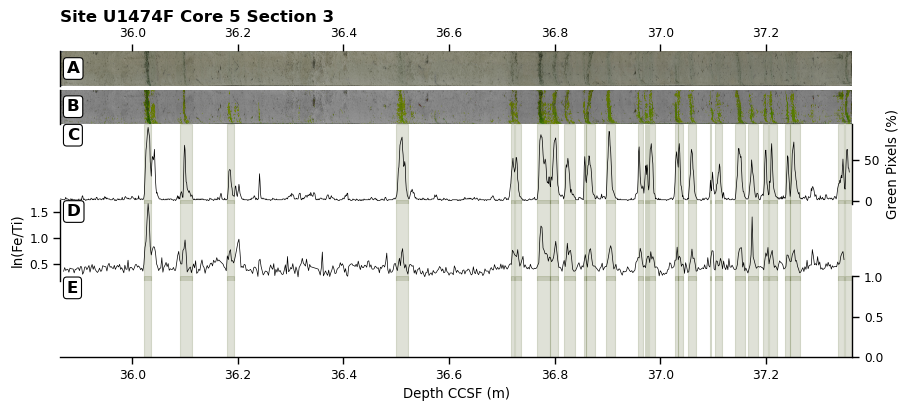

In [45]:
n=32
numbers=[n]
sns.set_context('paper')
################################ Set up
fig=plt.figure(figsize=(9,4.3),facecolor='white')
gs = gridspec.GridSpec(8, 1, figure=fig,hspace=-.1,left=.06,right=.94,top=.86,bottom=.14)

ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1,:])
ax3=fig.add_subplot(gs[2:4,:])
ax4=fig.add_subplot(gs[4:6,:])
ax5=fig.add_subplot(gs[6:,:])

### despine
for ax in [ax3,ax4,ax5]:
    ax.patch.set_alpha(0)
ax3.xaxis.set_visible(False)
ax4.xaxis.set_visible(False)
for ax in [ax1,ax2]:
    ax.patch.set_alpha(0)
    
sns.despine(ax=ax3,top=True,bottom=True,right=False,left=True)
sns.despine(ax=ax4,top=True,bottom=True,right=True,left=False)
sns.despine(ax=ax5,top=True,bottom=False,right=False,left=True)

ax3.yaxis.set_label_position('right')

################################ Plot 

#################### Images

sect=sections[n]
sect_length=(section_list.loc[sect,'Bottom Depth CCSF (m)']-
              section_list.loc[sect,'Top Depth CCSF (m)'])
extentlist=[section_list.loc[sect,'Bottom Depth CCSF (m)'],
            section_list.loc[sect,'Top Depth CCSF (m)'],0,sect_length/aspects[n]]

ax1.imshow(rphot[sect].rotate(180, Image.NEAREST, expand = 1),extent=extentlist)
ax2.imshow(fphot[sect].rotate(180, Image.NEAREST, expand = 1),extent=extentlist)

for ax in [ax1,ax2]:
    sns.despine(ax=ax,top=True,bottom=True,left=False,right=True)
    ax.yaxis.set_visible(False)
    
ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax5.set_xlabel('Depth CCSF (m)')

### setup columns
feti=ulxrf.loc[(ulxrf['SectionLabel']==sect)&(ulxrf['Masked']==False),'Fe/Ti'].apply(np.log)
green_data=green.loc[green['SectionLabel']==sect,'Green%']

ax3.plot(green_data.index,green_data.values,color='k',lw=.5)
ax4.plot(feti.dropna().index,feti.dropna(),color='k',lw=.5)

###### Title
ax1.annotate('Site '+sect[:6]+' Core '+sect[7]+' Section '+sect[9],
            xy=(0,2),xycoords='axes fraction',
            verticalalignment='center',horizontalalignment='left',fontweight='bold',
            size=12)

################################### coloring
sect_top=section_list.loc[sect,'Top Depth CCSF (m)']
sect_bottom=section_list.loc[sect,'Bottom Depth CCSF (m)']
#### green
sect_green=green_layers.loc[(green_layers['Top Depth CCSF (m)']>=sect_top-.1)&
                            (green_layers['Bottom Depth CCSF (m)']<=sect_bottom+.1)&
                            (green_layers['Top Depth CCSF (m)']>=green_data.index.min()-.1)&
                            (green_layers['Bottom Depth CCSF (m)']<=green_data.index.max()+.1)]

for gl in sect_green.index:
    if sect_green.loc[gl,'Class']==1:
        c='#606C38'
        for ax in [ax3,ax4,ax5]:
            ax.axvspan(xmin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                       xmax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                       color=c,zorder=-1,alpha=.2)
    elif sect_green.loc[gl,'Class']==2:
        c='#606C38'
        for ax in [ax3,ax4,ax5]:
            ax.axvspan(xmin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                       xmax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                       color=c,zorder=-1,alpha=.2)
    elif sect_green.loc[gl,'Class']==3:
        c='#606C38'
        for ax in [ax3,ax4,ax5]:
            ax.axvspan(xmin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                       xmax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                       color=c,zorder=-1,alpha=.2)
            

### Labels
ax3.set_ylabel('Green Pixels (%)')
ax4.set_ylabel('ln(Fe/Ti)')

### ylims
for i,a in enumerate([ax1,ax2,ax3,ax4,ax5]):
    a.set_xlim(section_list.loc[sect,'Top Depth CCSF (m)'],
               section_list.loc[sect,'Bottom Depth CCSF (m)'])
    
ax1.annotate('A',xy=(0.008,.5),ha='left',va='center',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
ax2.annotate('B',xy=(0.008,.5),ha='left',va='center',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
ax3.annotate('C',xy=(0.008,.95),ha='left',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
ax4.annotate('D',xy=(0.008,.95),ha='left',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
ax5.annotate('E',xy=(0.008,.95),ha='left',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))

# fig.savefig(figure_path+'Figure 3 - Green banding at U1474.png',dpi=300)

## Pyrite and d18O

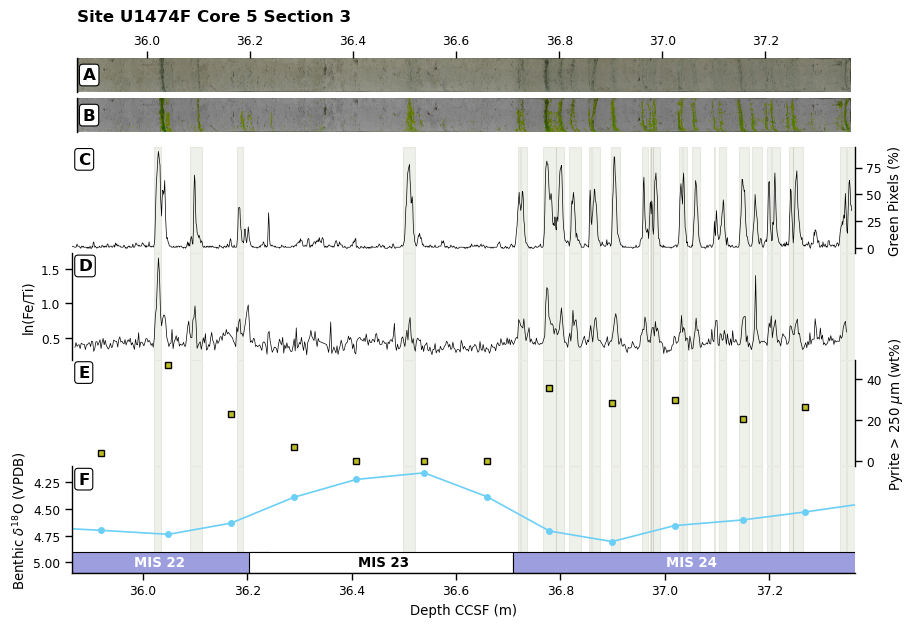

In [46]:
n=32
numbers=[n]
sns.set_context('paper')
################################ Set up
fig=plt.figure(figsize=(9,6.2),facecolor='white')

gs = gridspec.GridSpec(6, 1, figure=fig,right=.94,left=.07,top=.91,bottom=.08)

gsA = gs[:1].subgridspec(2,1,)
gsB = gs[1:].subgridspec(4,1,hspace=0)

ax1=fig.add_subplot(gsA[0])
ax2=fig.add_subplot(gsA[1])
ax3=fig.add_subplot(gsB[0])
ax4=fig.add_subplot(gsB[1])
ax5=fig.add_subplot(gsB[2])
ax6=fig.add_subplot(gsB[3])

### despine
for ax in [ax3,ax4,ax5,ax6]:
    ax.patch.set_alpha(0)
ax3.xaxis.set_visible(False)
ax4.xaxis.set_visible(False)
ax5.xaxis.set_visible(False)
for ax in [ax1,ax2]:
    ax.patch.set_alpha(0)
    
sns.despine(ax=ax3,top=True,bottom=True,right=False,left=True)
sns.despine(ax=ax4,top=True,bottom=True,right=True,left=False)
sns.despine(ax=ax5,top=True,bottom=True,right=False,left=True)
sns.despine(ax=ax6,top=True,bottom=False,right=True,left=False)

ax3.yaxis.set_label_position('right')
ax5.yaxis.set_label_position('right')

################################ Plot 

#################### Images

sect=sections[n]
sect_length=(section_list.loc[sect,'Bottom Depth CCSF (m)']-
              section_list.loc[sect,'Top Depth CCSF (m)'])
extentlist=[section_list.loc[sect,'Bottom Depth CCSF (m)'],
            section_list.loc[sect,'Top Depth CCSF (m)'],0,sect_length/aspects[n]]

##### Subplots 
ax1.imshow(rphot[sect].rotate(180, Image.NEAREST, expand = 1),extent=extentlist)
ax2.imshow(fphot[sect].rotate(180, Image.NEAREST, expand = 1),extent=extentlist)

for ax in [ax1,ax2]:
    sns.despine(ax=ax,top=True,bottom=True,left=False,right=True)
    ax.yaxis.set_visible(False)
    
ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax5.set_xlabel('Depth CCSF (m)')

### setup columns
feti=ulxrf.loc[(ulxrf['SectionLabel']==sect)&(ulxrf['Masked']==False),'Fe/Ti'].apply(np.log)
green_data=green.loc[green['SectionLabel']==sect,'Green%']

### data
ax3.plot(green_data.index,green_data.values,color='k',lw=.5)
ax4.plot(feti.dropna().index,feti.dropna(),color='k',lw=.5)
# ax5.plot(cf.index,cf['Pyrite > 250 (mg/g sample)']/10,ls='--',color=sns.color_palette()[-2],alpha=.2)
ax5.plot(cf.index,cf['Pyrite > 250 (mg/g sample)']/10,marker='s',ls='',color=sns.color_palette()[-2],markeredgecolor='k',mew=1)

ax6.plot(cf.index,cf['Benthic d18O (VPDB)'],marker='o',color='#6CCFF6',ms=4)
ax6.set_ylim(4.1,5.1)
ax6.invert_yaxis()      
ax6.axvspan(xmin=mis_depths.loc[22,'Top Depth (m)'],
            xmax=mis_depths.loc[22,'Bottom Depth (m)']+.02,color=colors[3],ec='k',ymax=.2)     
ax6.axvspan(xmin=mis_depths.loc[23,'Top Depth (m)']-.02,
            xmax=mis_depths.loc[23,'Bottom Depth (m)']+.06,color='w',ec='k',ymax=.2)  
ax6.axvspan(xmin=mis_depths.loc[24,'Top Depth (m)']+.06,
            xmax=mis_depths.loc[24,'Bottom Depth (m)'],color=colors[3],ec='k',ymax=.2)

ax6.annotate('MIS 22',xy=(36.08,5),xycoords='data',ha='right',va='center',fontweight='bold',color='w')
ax6.annotate('MIS 23',xy=(36.51,5),xycoords='data',ha='right',va='center',fontweight='bold',color='k')
ax6.annotate('MIS 24',xy=(37.1,5),xycoords='data',ha='right',va='center',fontweight='bold',color='w')

###### Title
ax1.annotate('Site '+sect[:6]+' Core '+sect[7]+' Section '+sect[9],
            xy=(0,2.25),xycoords='axes fraction',
            verticalalignment='center',horizontalalignment='left',fontweight='bold',
            size=12)

################################### coloring
sect_top=section_list.loc[sect,'Top Depth CCSF (m)']
sect_bottom=section_list.loc[sect,'Bottom Depth CCSF (m)']
#### green
sect_green=green_layers.loc[(green_layers['Top Depth CCSF (m)']>=sect_top-.1)&
                            (green_layers['Bottom Depth CCSF (m)']<=sect_bottom+.1)&
                            (green_layers['Top Depth CCSF (m)']>=green_data.index.min()-.1)&
                            (green_layers['Bottom Depth CCSF (m)']<=green_data.index.max()+.1)]

for gl in sect_green.index:
    if sect_green.loc[gl,'Class']==1:
        c='#606C38'
        for ax in [ax3,ax4,ax5,ax6]:
            ax.axvspan(xmin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                       xmax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                       color=c,zorder=-1,alpha=.1)
    elif sect_green.loc[gl,'Class']==2:
        c='#606C38'
        for ax in [ax3,ax4,ax5,ax6]:
            ax.axvspan(xmin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                       xmax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                       color=c,zorder=-1,alpha=.1)
    elif sect_green.loc[gl,'Class']==3:
        c='#606C38'
        for ax in [ax3,ax4,ax5,ax6]:
            ax.axvspan(xmin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                       xmax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                       color=c,zorder=-1,alpha=.1)

### Labels
ax3.set_ylabel('Green Pixels (%)')
ax4.set_ylabel('ln(Fe/Ti)')
ax5.set_ylabel('Pyrite > 250 $\mu$m (wt%)')
ax6.set_ylabel('Benthic $\delta^{18}$O (VPDB)')
ax6.set_xlabel('Depth CCSF (m)')

### ylims
for i,a in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    a.set_xlim(section_list.loc[sect,'Top Depth CCSF (m)'],
               section_list.loc[sect,'Bottom Depth CCSF (m)'])
    
ax1.annotate('A',xy=(0.008,.5),ha='left',va='center',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
ax2.annotate('B',xy=(0.008,.5),ha='left',va='center',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
ax3.annotate('C',xy=(0.008,.95),ha='left',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
ax4.annotate('D',xy=(0.008,.95),ha='left',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
ax5.annotate('E',xy=(0.008,.95),ha='left',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
ax6.annotate('F',xy=(0.008,.95),ha='left',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))

fig.savefig(figure_path+'Figure 3 - Green banding at U1474.png',dpi=300)